
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Визуаилизировать embeddings по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
  homer - marge + bart
  bart - lisa + school
  marge - homer + home
5.  попробовать построить классификатор bart/lisa с использованием этих эмбеддингов


## 1. Скачать датасет с фразами симпосонов - 
https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data

In [1]:
!wget https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip

--2021-01-03 20:02:28--  https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data/raw/master/simpsons_script_lines.csv.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip [following]
--2021-01-03 20:02:28--  https://raw.githubusercontent.com/sujanjoejacob/Text-mining-with-Simpsons-Data/master/simpsons_script_lines.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9163442 (8.7M) [application/zip]
Saving to: ‘simpsons_script_lines.csv.zip’

simpsons_script_lin 100%[===================>]   8.74M  --.-KB/s    i

In [2]:
!unzip simpsons_script_lines.csv.zip

Archive:  simpsons_script_lines.csv.zip
  inflating: simpsons_script_lines.csv  


## 2. Обучить Word2Vec на фразах персонажей

In [3]:
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import Counter
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
simpsons = pd.read_csv('simpsons_script_lines.csv', error_bad_lines=False)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

In [5]:
simpsons.dropna(inplace = True)

In [6]:
simpsons.head(5)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [7]:
simpsons = simpsons.sort_values(by = 'id')

In [8]:
simpsons.tail()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
147762,158303,568,193,Homer Simpson: I'm not leaving this casino unt...,1211000,true,2,4457.0,Homer Simpson,CASINO FLOOR,I'm not leaving this casino until you stop pun...,im not leaving this casino until you stop puni...,21.0
147766,158308,568,198,"Marge Simpson: Homie, after all this, do you s...",1227000,true,1,131.0,Marge Simpson,First Church of Springfield,"Homie, after all this, do you still believe in...",homie after all this do you still believe in god,10.0
147767,158309,568,199,Homer Simpson: On a beautiful night like tonig...,1230000,true,2,131.0,Homer Simpson,First Church of Springfield,On a beautiful night like tonight... how could...,on a beautiful night like tonight how could i not,10.0
147769,158311,568,201,"Lou: Next week on ""Sky Police"".",1292000,true,91,3.0,Lou,Springfield Elementary School,"Next week on ""Sky Police"".",next week on sky police,5.0
147773,158315,568,205,Chief Wiggum: Sky police!,1292000,true,71,585.0,Chief Wiggum,Warehouse District,Sky police!,sky police,2.0


In [9]:
phrases = simpsons['normalized_text'].to_list()

In [10]:
episodes = simpsons['episode_id'].unique()
len(episodes)

564

In [11]:
# соединение списка фраз в один текст, без цифр
def phrases_to_text(phrases):
  text = ''
  number_digits = 0
  for i in range(len(phrases)):
    if not str(phrases[i]).isdigit():
      text += ' ' + str(phrases[i])
    else:
      number_digits += 1
  if number_digits != 0:
    print('Число удаленных цифр в тексте', number_digits)
  
  return text

In [12]:
query = phrases_to_text(phrases)

Число удаленных цифр в тексте 10


In [13]:
# исходная длина словаря
len(set(query.split()))

46773

Удалим редкие слова (встречаются 1 раз) из текста

In [14]:
cnt = Counter(query.split())

In [15]:
# список редких слов
rare_words = []
for key in cnt:
  if cnt[key] == 1:
    rare_words.append(key)

In [16]:
rare_words = set(rare_words)
querywords = query.split()
resultwords  = [word for word in querywords if word not in rare_words]

In [17]:
len(resultwords),len(rare_words)

(1279162, 22808)

In [18]:
vocabulary = set(resultwords)
len(vocabulary)

23965

словарь сократился на **22808** слов

In [19]:
w2i = {w: i for i, w in enumerate(vocabulary)}
i2w = {i: w for i, w in enumerate(vocabulary)}

In [20]:
# здесь создается датасет для тренировки CBOW 
#  основная идея метода - выделение отдельных эпизодов, 
#как объединенных единым смыслом участков текста для создания правильного контекста
# context window size is four
def create_cbow_dataset(df, rare_words):
  episodes = df['episode_id'].unique()
  data = []
  for episode in episodes:
    ep_frame = df[df['episode_id'] == episode]
    ep_frame =  ep_frame.sort_values(by = 'id')
    episode_phrases = ep_frame['normalized_text'].to_list()
    text = phrases_to_text(episode_phrases)
    querywords = text.split()
    text  = [word for word in querywords if word not in rare_words]

    for i in range(4, len(text) - 4):
        context = [text[i - 4],text[i - 3], text[i - 2],text[i - 1],
                   text[i + 1], text[i + 2],text[i + 3], text[i + 4]]
        target = text[i]
        data.append((context, target))
  return data

In [21]:
cbow_train = create_cbow_dataset(simpsons,rare_words)

Число удаленных цифр в тексте 5
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1
Число удаленных цифр в тексте 1


In [22]:
len(cbow_train)

1274650

In [23]:
print('cbow sample', cbow_train[21112])

cbow sample (['oh', 'i', 'dont', 'want', 'trouble', 'you', 'not', 'at'], 'to')


In [24]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((inputs.shape[0], -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

In [25]:
# подготовка массива для обучения
# превращение слов в контекст и таргет (Torch tensor ) из наборов  cbow_train
TRAIN = []
for context, target in cbow_train:
  ctx_idxs = [w2i[w] for w in context]
  ctx_idxs = torch.LongTensor(ctx_idxs)
  TRAIN.append((ctx_idxs,torch.LongTensor([w2i[target]])))


In [26]:
TRAIN[4]

(tensor([15436, 10592, 23902,  2235, 20528, 21795,  8879,  5866]),
 tensor([8402]))

In [27]:
len(TRAIN)

1274650

In [28]:
BATCH_SIZE = 900
train_iter = torch.utils.data.DataLoader(TRAIN, batch_size=BATCH_SIZE, shuffle = True)

In [32]:
embd_size = 300
learning_rate = 2.0
n_epoch = 50
vocab_size = len(vocabulary)
CONTEXT_SIZE = 4  # 4 words to the left, 4 to the right

hidden_size = 300
losses = []
loss_fn = nn.NLLLoss()
#model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
ep = [i for i in range(n_epoch)]
for epoch in ep:
    print(f'===========epoch=={epoch}===========')
    total_loss = .0
    for context, target in train_iter:
        context,target = context.cuda(), target.cuda()
        #print(context.shape)
        #context = context.unsqueeze(0)
        #print(context.shape)
        #print(target.shape)
        model.zero_grad()
        log_probs = model(context)
        #print('OUTPUT', log_probs.shape)
        target = target.squeeze()
        #print('TARGET',target.shape)
        loss = loss_fn(log_probs, target)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f'loss = {total_loss}')
    losses.append(total_loss)

===========epoch==0===========
loss = 8438.677681922913
===========epoch==1===========
loss = 7455.562999725342
===========epoch==2===========
loss = 7054.900854587555
===========epoch==3===========
loss = 6763.6193079948425
===========epoch==4===========
loss = 6527.7052211761475
===========epoch==5===========
loss = 6327.290376186371
===========epoch==6===========
loss = 6144.9676425457
===========epoch==7===========
loss = 5984.74595618248
===========epoch==8===========
loss = 5836.978314399719
===========epoch==9===========
loss = 5702.431041717529
===========epoch==10===========
loss = 5580.92909860611
===========epoch==11===========
loss = 5473.9995748996735
===========epoch==12===========
loss = 5374.620442390442
===========epoch==13===========
loss = 5286.448509454727
===========epoch==14===========
loss = 5203.980040311813
===========epoch==15===========
loss = 5128.716571092606
===========epoch==16===========
loss = 5060.1421592235565
===========epoch==17===========
loss = 50

In [33]:
sample_to_test = [cbow_train[random.randint(1,len(cbow_train))] for i in range(900)]

In [34]:
model.cpu()

CBOW(
  (embeddings): Embedding(23965, 300)
  (linear1): Linear(in_features=2400, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=23965, bias=True)
)

In [35]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))
        ctx_var = ctx_var.unsqueeze(0)
        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        if predicted_word == target:
            correct_ct += 1
        print('label :', target)
        print('predicted:', predicted_word)
             
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

In [36]:
test_cbow(sample_to_test,model)

====Test CBOW===
label : hearings
predicted: hearings
label : oh
predicted: could
label : did
predicted: gotta
label : soaking
predicted: soaking
label : em
predicted: made
label : hello
predicted: hey
label : perhaps
predicted: and
label : why
predicted: why
label : or
predicted: well
label : excellent
predicted: excellent
label : dear
predicted: dear
label : you
predicted: you
label : in
predicted: from
label : unhook
predicted: unhook
label : steering
predicted: steering
label : scares
predicted: scares
label : women
predicted: and
label : summer
predicted: summer
label : at
predicted: know
label : there
predicted: up
label : count
predicted: be
label : i
predicted: i
label : with
predicted: have
label : getting
predicted: in
label : happened
predicted: happened
label : seen
predicted: seen
label : wanted
predicted: expect
label : dinner
predicted: hey
label : of
predicted: of
label : and
predicted: and
label : mesmerino
predicted: mesmerino
label : wake
predicted: wake
label : bori

<Figure size 432x288 with 0 Axes>

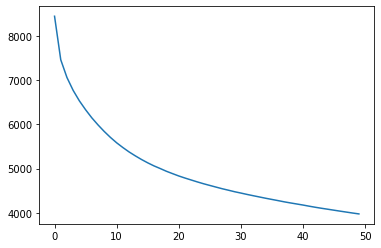

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(losses, 'CBOW Losses')

## 3. Визуаилизировать embeddings по самым частотным словам (top 1000)

In [39]:
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
from pylab import rcParams
rcParams['figure.figsize'] = 20,12

In [40]:
phrases = simpsons['normalized_text'].to_list()

In [41]:
sentences = []
for phrase in phrases:
  phrase_words = [word for word in phrase.split() if word not in rare_words]
  sentences.append(phrase_words)

In [42]:
sentences[:4]

[['ooo', 'careful', 'homer'],
 ['theres', 'no', 'time', 'to', 'be', 'careful'],
 ['were', 'late'],
 ['sorry', 'excuse', 'us', 'pardon', 'me']]

In [43]:
# train model
model = Word2Vec(sentences, min_count=2)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
#print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=23965, size=100, alpha=0.025)
[ 0.1584052   0.06012415  0.03424594  0.09561067  0.22039978 -0.26973468
 -0.00667914  0.32798955 -0.0038379   0.08585948 -0.2604871   0.25678408
 -0.04033848  0.13287264 -0.03483397 -0.20544834  0.00046483  0.2849004
  0.38130915 -0.02132821  0.391639   -0.01157263 -0.02319028 -0.25243634
  0.22097826 -0.24039643  0.21863353 -0.02933987  0.16630742  0.06198176
  0.15115903  0.20579332 -0.13762666  0.11667132 -0.00608624 -0.06650642
 -0.10209158  0.09858853 -0.14479244  0.08641774  0.09415796  0.05423806
  0.12460729  0.04832033 -0.12673038  0.16148755  0.1789927  -0.1584928
  0.04723481  0.27426162 -0.0402004   0.1205068  -0.1833313  -0.05760165
  0.3116295  -0.18924461  0.15220782 -0.13163231  0.06340615 -0.18422851
 -0.08026051 -0.26882926  0.2184482   0.06695839 -0.34120622 -0.05230239
 -0.10047033  0.1802782  -0.15564895 -0.10769454 -0.07020517  0.05258073
 -0.00634794  0.00164054 -0.01737892  0.18231195  0.0646663   0.03121923
  0.1450

In [44]:
def plot_most_common_word(df,model,rare_words,n = 100):
  phrases = df['normalized_text'].to_list()
  text = phrases_to_text(phrases)
  querywords = text.split()
  resultwords  = [word for word in querywords if word not in rare_words]
  cntr = Counter(resultwords)
  top_n = cntr.most_common(n)
  most_common = []

  for word,count in top_n:
    most_common.append(word)
  
  X = model[most_common]

  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  plt.scatter(result[:, 0], result[:, 1])
  words = most_common
  for i, word in enumerate(words):
	  plt.annotate(word, xy=(result[i, 0], result[i, 1]))
  plt.show()

In [45]:
rcParams['figure.figsize'] = 16,10

Число удаленных цифр в тексте 10


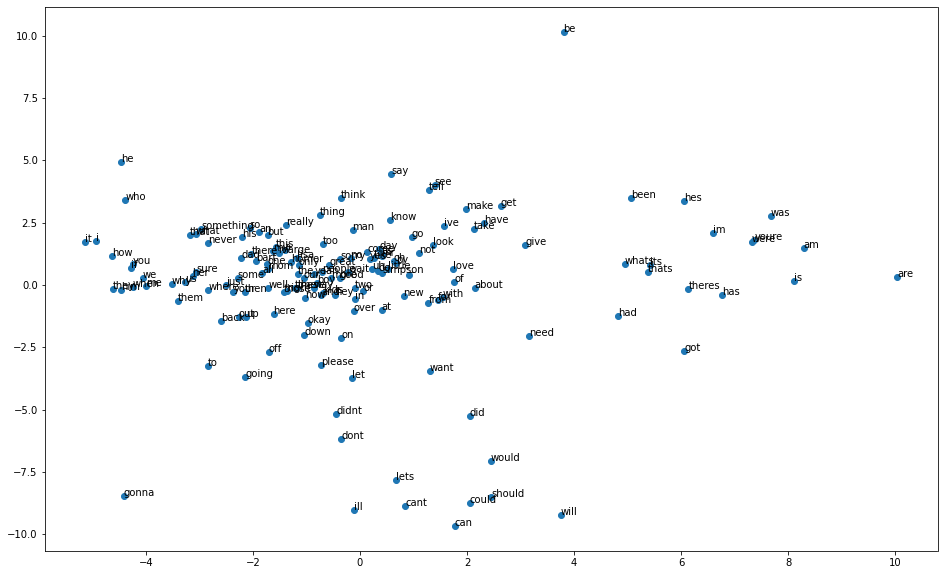

In [46]:
plot_most_common_word(simpsons,model,rare_words,n=150)

Число удаленных цифр в тексте 10


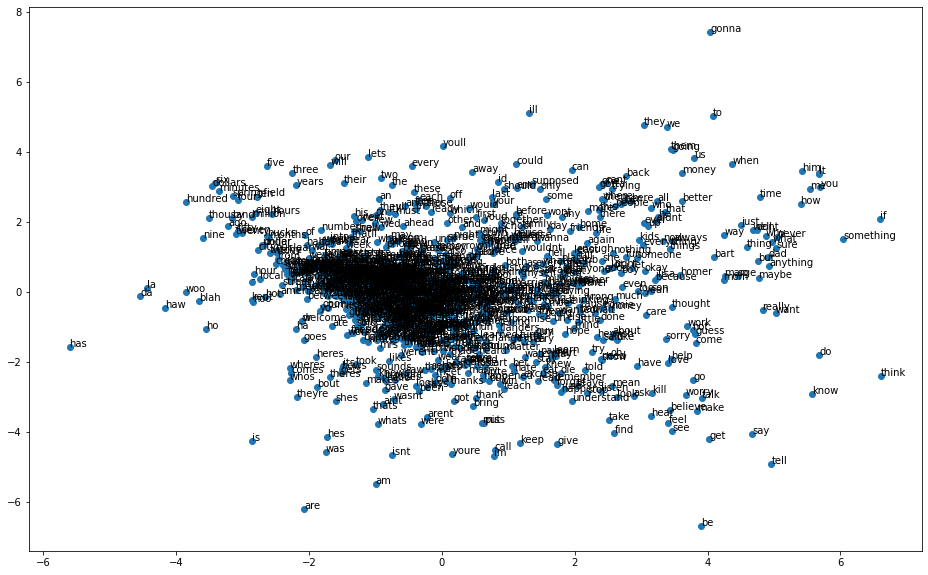

In [47]:
plot_most_common_word(simpsons,model,rare_words,n=1000)

##4. Найти самые близкие слова для:
  homer - marge + bart

  bart - lisa + school
  
  marge - homer + home

In [48]:
new_model

In [49]:
# calculate: homer - marge + bart
result = new_model.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=5)
print(result)

[('lisa', 0.8088754415512085), ('milhouse', 0.6684340238571167), ('grampa', 0.6568875312805176), ('abe', 0.6315867304801941), ('dad', 0.6124290227890015)]


In [50]:
# calculate: bart - lisa + school
result = new_model.most_similar(positive=['school', 'bart'], negative=['lisa'], topn=5)
print(result)

[('store', 0.7364215850830078), ('church', 0.7297276258468628), ('game', 0.7246192693710327), ('house', 0.7161989808082581), ('christmas', 0.7110389471054077)]


In [51]:
# calculate: marge - homer + home
result = new_model.most_similar(positive=['marge', 'home'], negative=['homer'], topn=5)
print(result)

[('back', 0.7649878263473511), ('sleep', 0.7216026186943054), ('bed', 0.7139748930931091), ('here', 0.6332032680511475), ('away', 0.6177801489830017)]


## 5. Классификатор Bart/Lisa

In [52]:
import math
import numpy as np

In [53]:
new_model

In [54]:
model['marge']

array([ 0.19853958,  0.3492426 , -0.34410515,  0.18310864,  0.58753663,
       -0.9199358 , -0.15576996,  0.76840824,  0.30276307,  0.22165495,
       -1.5042725 ,  0.31104976, -0.6506246 ,  0.35177544,  0.3373222 ,
        0.08122038, -0.1002769 ,  0.2511405 ,  0.4272088 , -0.4880019 ,
        1.2271695 ,  0.51563096,  1.2759758 ,  0.70418817,  0.54245573,
        0.4878799 , -0.7904364 , -1.4486525 , -0.85598207, -1.1923677 ,
        0.1042343 ,  0.6484059 ,  0.12807205,  0.28334317, -0.869053  ,
       -0.23902154,  0.82755774,  0.9534054 , -0.3283206 ,  0.18489791,
        1.0344166 ,  2.209579  ,  0.00308554, -0.4117618 ,  1.329955  ,
       -0.32600683, -0.01063201, -1.1620154 , -0.5928622 ,  0.3923875 ,
        1.0794399 ,  1.3460897 , -0.9434755 , -0.8420717 , -0.14554437,
       -0.93703675, -0.02804806,  0.09630331, -0.43527642, -1.4345542 ,
       -0.07594731, -2.057619  ,  0.7656529 , -0.6494219 , -0.4737069 ,
       -0.87399966, -1.9705162 , -1.5316476 , -0.02055237, -0.60

In [55]:
def length(v):
  return math.sqrt(np.dot(v, v))

def cos_vectors(v1, v2):
  return np.dot(v1,v2) / (length(v1) * length(v2))

In [56]:
def bart_lisa_classificator(word2classificate,model):
  word_vector = model[word2classificate]
  bart_vector = model['bart']
  lisa_vector = model['lisa']
  bart_cos = cos_vectors(bart_vector,word_vector)
  lisa_cos = cos_vectors(lisa_vector,word_vector)
  bart_cos = round(bart_cos,3)
  lisa_cos = round(lisa_cos,3)
  if bart_cos > lisa_cos:
    print('This is Bart')
  elif lisa_cos > bart_cos:
    print('This is Lisa')
  else:
    print('The word  belongs both Bart and Lisa ')
  print('COS  for Bart', bart_cos)
  print('COS for Lisa', lisa_cos)
  return

In [57]:
bart_lisa_classificator('game',model)

This is Bart
COS  for Bart 0.434
COS for Lisa 0.347


In [58]:
bart_lisa_classificator('music',model)

This is Lisa
COS  for Bart 0.246
COS for Lisa 0.26


In [59]:
bart_lisa_classificator('jazz',model)

This is Lisa
COS  for Bart 0.218
COS for Lisa 0.29
